In [4]:
!pip install xgboost

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl (124.9 MB)


C:\Users\TomH\Anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\TomH\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       758
           1       0.47      0.33      0.39       243

    accuracy                           0.75      1001
   macro avg       0.64      0.61      0.61      1001
weighted avg       0.72      0.75      0.73      1001

Confusion Matrix:
[[669  89]
 [163  80]]
ROC AUC Score: 0.7024061587239541


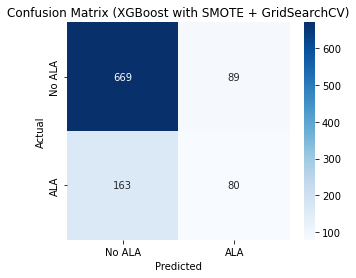

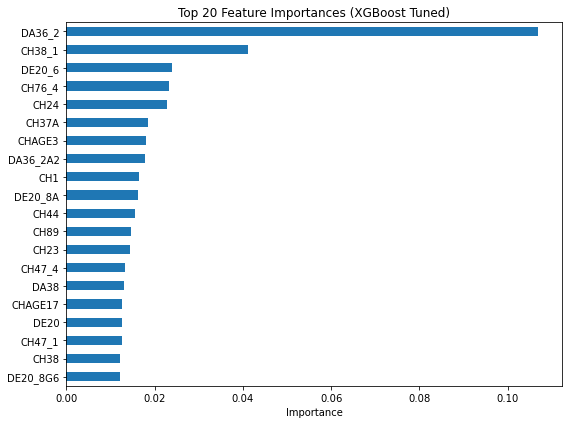

In [3]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load and prepare data
df = pd.read_csv("35067-0001-Data.tsv", sep="\t")
df = df[df['DSM_ALA'].isin([1, 5])].copy()
df['DSM_ALA_BINARY'] = df['DSM_ALA'].replace({5: 0, 1: 1})

# Select features
prefixes = ['CH', 'DA', 'DE']
demographic_cols = ['AGE', 'SEX', 'MARITAL', 'EDUC', 'EMPSTAT', 'INCOME']
core_features = [col for col in df.columns if any(col.startswith(p) for p in prefixes)]
available_demos = [col for col in demographic_cols if col in df.columns]
feature_cols = core_features + available_demos

X = df[feature_cols]
y = df['DSM_ALA_BINARY']
X = X.dropna(axis=1, how='all')

# Impute missing values
imputer = SimpleImputer(strategy="most_frequent")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Grid search on XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
grid.fit(X_balanced, y_balanced)

# Best model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predict and evaluate
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)
print("ROC AUC Score:", roc_auc)

# Feature importance
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No ALA', 'ALA'], yticklabels=['No ALA', 'ALA'])
plt.title("Confusion Matrix (XGBoost with SMOTE + GridSearchCV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(8,6))
importances.plot(kind='barh')
plt.title("Top 20 Feature Importances (XGBoost Tuned)")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
